In [3]:
#path = "input/AirPassengers.csv" #For local
path = "AirPassengers.csv" #For Kaggle
dataset = pd.read_csv(path)
#Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'],infer_datetime_format=True) #convert from string to datetime
indexedDataset = dataset.set_index(['Month'])
indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


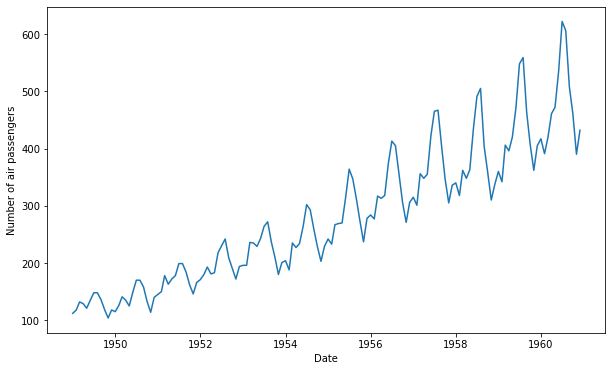

In [4]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

In [5]:
#Determine rolling statistics
rolmean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


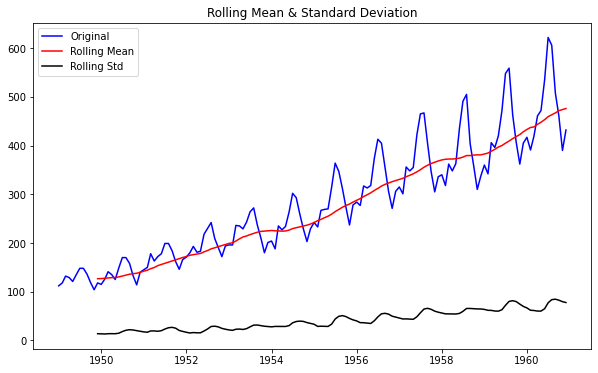

In [6]:
#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


In [7]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


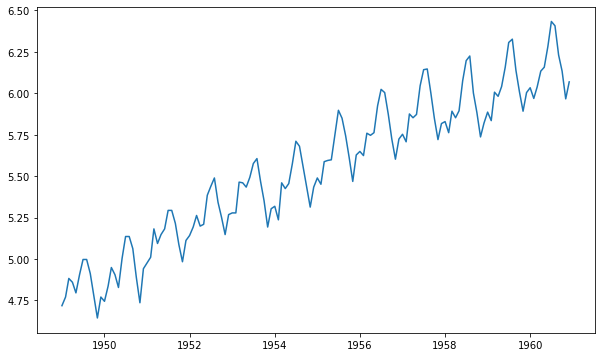

In [8]:
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

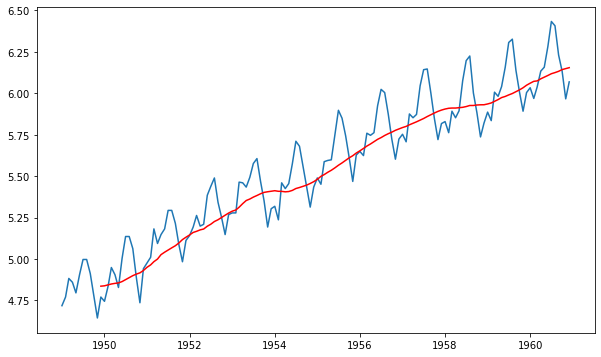

In [9]:
#The below transformation is required to make series stationary
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [10]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


In [11]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

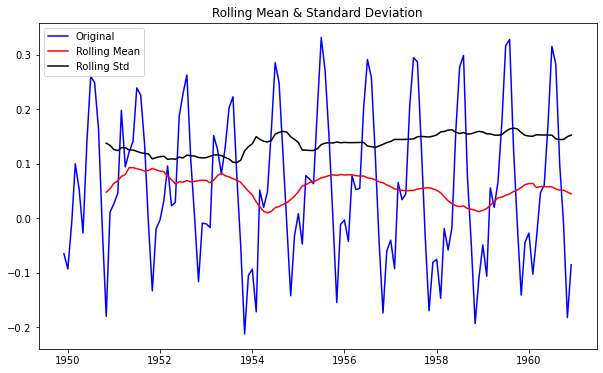

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [12]:
test_stationarity(datasetLogScaleMinusMovingAverage)

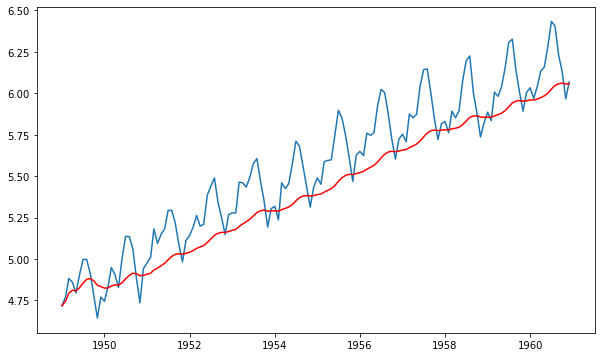

In [13]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

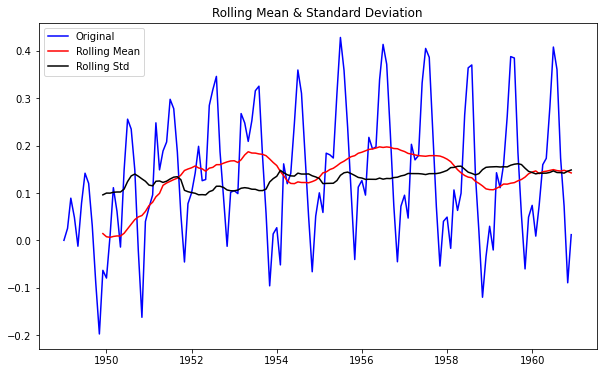

Results of Dickey Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [14]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

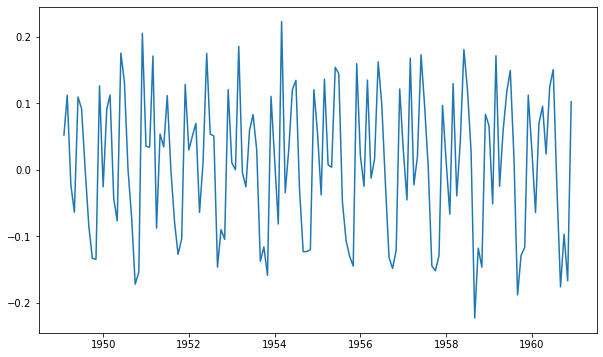

In [15]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

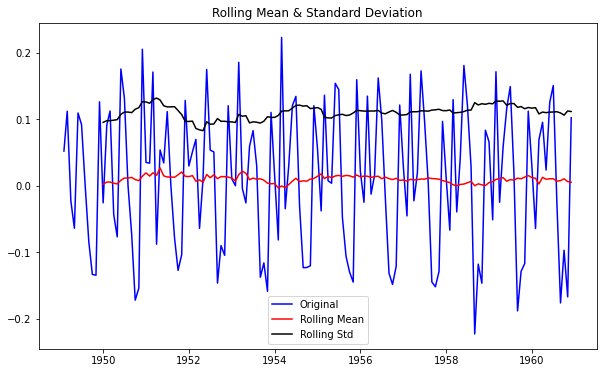

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [16]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


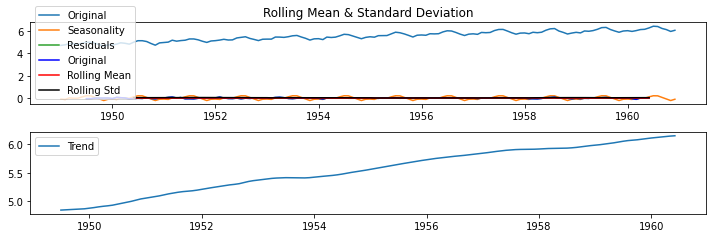

Results of Dickey Fuller Test:


KeyError: '#Passengers'

In [18]:

decomposition = seasonal_decompose(indexedDataset_logScale)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

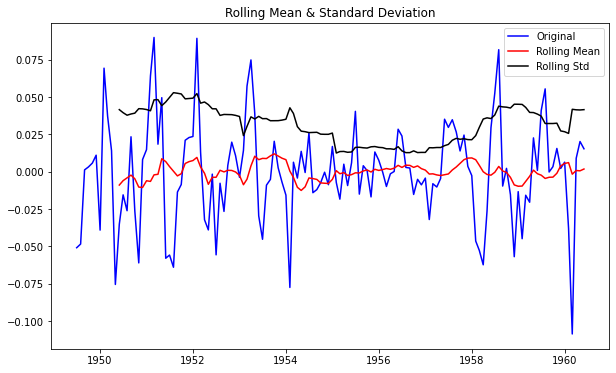

Results of Dickey Fuller Test:


KeyError: '#Passengers'

In [19]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


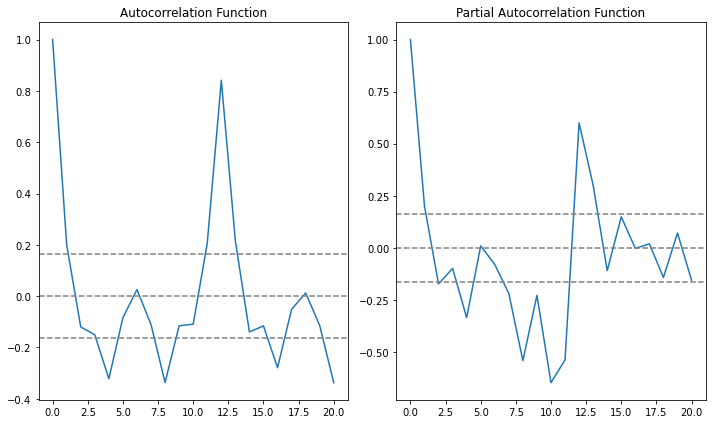

In [20]:

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


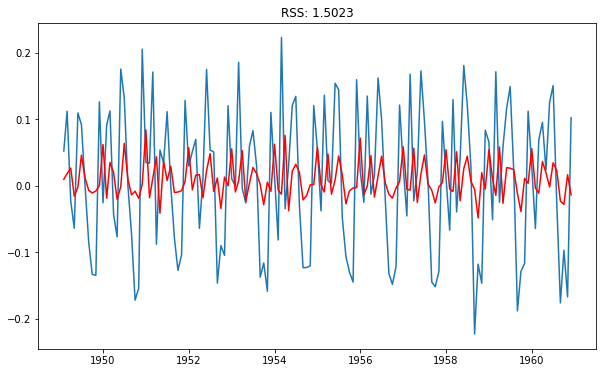

In [ ]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting AR model')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting MA model


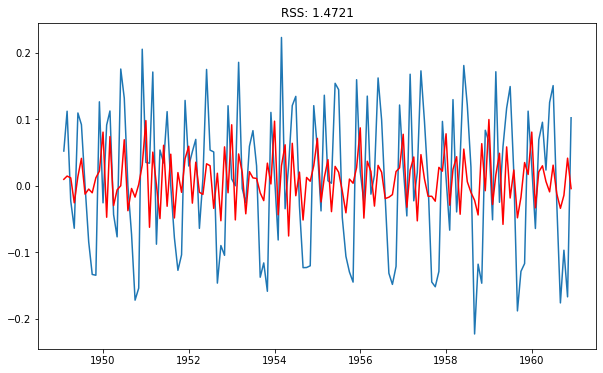

In [ ]:
#MA Model
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting MA model')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model


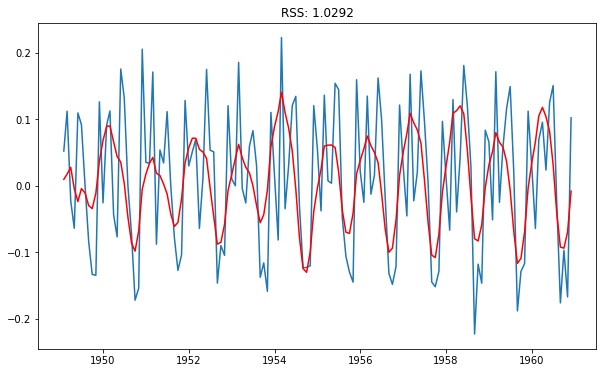

In [ ]:
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64


In [ ]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372554
1960-09-01    1.280204
1960-10-01    1.186191
1960-11-01    1.116267
1960-12-01    1.108140
Length: 143, dtype: float64


In [ ]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Passengers'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

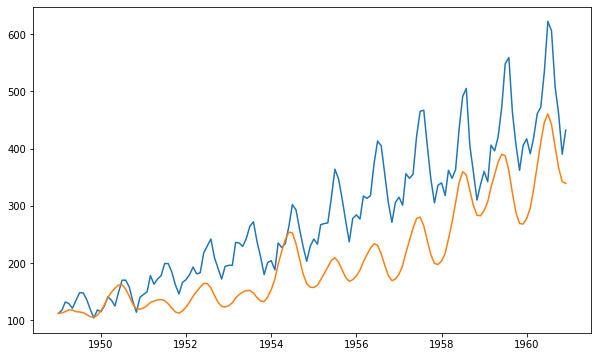

In [ ]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

In [ ]:
indexedDataset_logScale

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


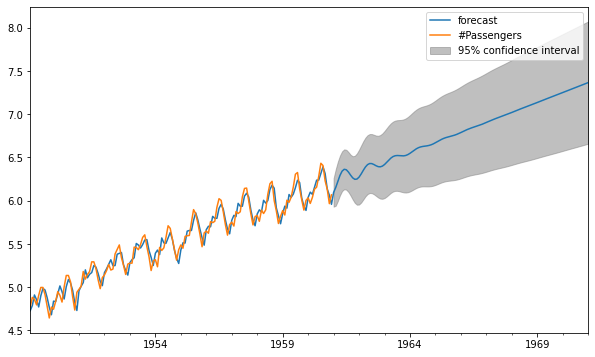

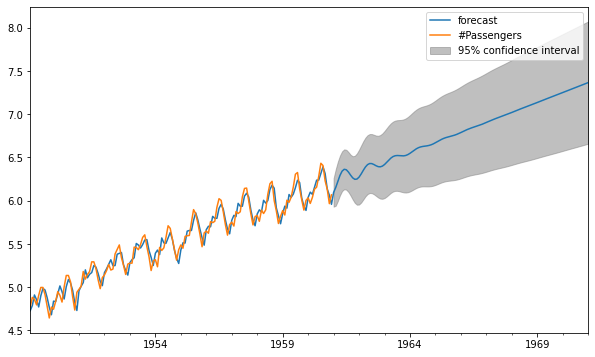

In [ ]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
results_ARIMA.plot_predict(1,264) 
#x=results_ARIMA.forecast(steps=120)

In [ ]:
#print(x[1])
#print(len(x[1]))
#print(np.exp(x[1]))